## General Model



## Import useful packages

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import boto3
import io
#from keras.utils import plot_model
import random
from botocore.exceptions import ClientError
import yaml
#import ktrain



In [3]:
with open('model.yml') as config_file:
    config_data = yaml.load(config_file)
    image_dir = config_data['image_dir']
    latstart= config_data['latstart']
    latend=config_data['latend']
    longstart = config_data['longstart']
    longend=config_data['longend']
    dtstart= config_data['dtstart']
    dtend=config_data['dtend']

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


## Define functions to load the data


#### This code gets list of keys (ie files) in S3 bucket
(Should consider moving this into a helper file.)

In [4]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                break

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    obj_list=[]
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        obj_list.append(obj["Key"])
    return(obj_list)


In [5]:
def haversine_loss(y_true, y_pred, denorm=(36.0, 4.0, -78.0, 4.0), R=3443.92):
    """
    Returns the mean squared haversine distance
    between arrays consisting of lattitudes and
    longitudes.
    
    Args:
        y_true:  Either an np.array or a tf.constant
                 of dimensions m x 2 where m in the
                 number of observations.  Each row is
                 an ordered pair of [lat, long].
                 
        y_pred:  Has the same form as y_true.
        
        dnorm:   A tuple of four values needed to
                 convert normalized lat and long back
                 to actual values.
        
        R:       Float giving the radius of the earth.
                 The default value is in nautical
                 miles.  Values in other units:
                 
                 kilometers    -> 6378.14
                 statute miles -> 3963.19
                 smoots        -> 3.748e+6
        
    Returns:
        tf.tensor of shape () and dtype float64 giving
        the mean square distance error using the
        haversine function.
    
    Examples:
    
        Input:
        y1     = np.array([[0, 0]])
        y_hat1 = np.array([[0, 180]])
        
        Expected result:
        (pi * R) ** 2 = 117059281.6 nm^2
        
        Input:
        y2     = np.array([[0, 0]])
        y_hat2 = np.array([[90, 0]])
        
        Expected result:
        (pi * R / 2) ** 2 = 29264820.4 nm^2
        
        Input:
        Portmsouth, VA to Rota, Spain
        y3     = tf.constant([[36.8354, -76.2983]])
        y_hat3 = tf.constant([[36.6237, -6.3601]])
        
        Expected result:
        37065212.0 km^2
        
    Notes:
        Closely follows the JS implmentation at
        https://www.movable-type.co.uk/scripts/latlong.html.
    """
    # Break inputs into lattitudes and longitudes for
    # convienience

    # Convert normalized lat and long into actuals
    lat_min, lat_range, long_min, long_range = denorm
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c
    
    # Compute the mean squared distance (MSE)
    return tf.reduce_mean(d)

### Key image read-in functions: load_image and build_input

In [6]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [7]:
def build_input(s3_client,bucket_name,file_list,files_to_load,dim):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file,dim)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [8]:
def build_labels(file_list,files_to_load):
    y = []
    t=[]
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            time = file_split[2].split('.')[0]
            y.append((lat, long))
            t.append(time)
    return np.array(y),np.array(t)

#### Test load_image on one image manually

(224, 224)
[[ 36.00147625 -74.82905304]] ['2020-05-26T01:10:59']


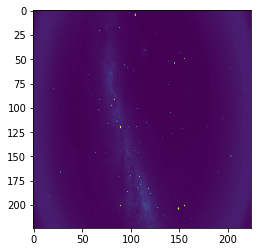

In [9]:
bucket_name='w251-final-project'
file_name='36.0014762509164+-74.82905304191733+2020-05-26T01:10:59.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name)
plt.imshow(sample_image)
print(sample_image.shape)
file_list=[file_name]
test_label, test_time=build_labels(file_list,1)
print (test_label,test_time)

## Prepare the data

### Load the images

In [76]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=False

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')
    t=np.load('t.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=5000
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('About to call build_input on',files_to_load,' files')
    dim=(224,224)
    X = build_input(s3,bucket_name,file_list,files_to_load,dim)


    #get labels
    print ('Building labels')
    y,t = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
    np.save('x.npy',X)
    np.save('y.npy',y)
    np.save('t.npy',y)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)
print ('shape of time list:',t.shape)

loading from S3
About to call build_input on 5000  files
37.033448366008585+-76.93576309476725+2020-05-26T00:30:34.png
loaded: 0
38.48422232694745+-75.13234866712124+2020-05-26T00:15:29.png
38.51584232977527+-74.84201385593147+2020-05-26T00:51:11.png
39.134546887424555+-77.81852710328884+2020-05-26T00:08:08.png
36.02738256891932+-77.63302585130515+2020-05-25T22:31:32.png
36.330245785496324+-74.42870469953014+2020-05-26T00:35:21.png
37.20971000230824+-75.68306533235848+2020-05-26T01:47:26.png
37.7540901638416+-76.87878508160149+2020-05-25T23:22:24.png
39.1918051144593+-77.57332672688203+2020-05-26T01:02:44.png
39.87587664836948+-74.60913137648505+2020-05-25T22:05:31.png
39.10699774518767+-74.19138423148951+2020-05-26T00:21:32.png
38.08001251249992+-76.39777473865644+2020-05-25T22:14:03.png
39.857101172175376+-77.79567243641827+2020-05-26T01:58:38.png
38.43681619372982+-76.158222138368+2020-05-25T22:04:52.png
38.31398211444639+-74.85642567233582+2020-05-26T01:45:37.png
37.82827533802707+

37.223588002577536+-77.10453238996921+2020-05-26T01:03:16.png
37.521177060682106+-75.92096897190373+2020-05-25T22:24:07.png
37.28263897513744+-74.64446650405807+2020-05-25T23:52:27.png
39.400713275814596+-77.61107161503278+2020-05-26T00:27:11.png
39.00453123804205+-74.0292332648348+2020-05-26T01:37:29.png
39.007843786457755+-77.98839252628858+2020-05-25T23:30:49.png
39.573342333906034+-77.3843324175433+2020-05-26T00:33:58.png
39.389028959961834+-75.4463077191366+2020-05-25T22:07:23.png
37.57499130596826+-75.81651322689979+2020-05-25T22:05:54.png
39.363211042325176+-77.03788613050482+2020-05-26T01:45:32.png
39.11455654373627+-74.52691851249168+2020-05-26T01:27:33.png
36.29706977341861+-76.25586286302423+2020-05-25T22:26:29.png
39.86682748629993+-75.96262876237685+2020-05-26T01:07:19.png
37.67229248301151+-77.15200700759817+2020-05-26T01:23:01.png
38.02259831869462+-74.1116701276021+2020-05-26T01:54:46.png
37.35726943528425+-74.52776234302476+2020-05-25T23:48:07.png
38.536235386599685+-7

38.04430126943058+-76.33008306248536+2020-05-25T23:04:33.png
37.36195426100591+-77.87461116896002+2020-05-26T01:48:41.png
39.382862039563456+-75.62077604694916+2020-05-26T00:37:52.png
36.83555445949023+-76.76012037439374+2020-05-26T01:33:40.png
36.37195357958267+-76.3515774152799+2020-05-26T01:43:42.png
38.626178889446955+-76.44894146986759+2020-05-26T00:31:40.png
39.979461611018074+-76.49401670441802+2020-05-26T00:40:39.png
39.60638114225299+-74.55190044666959+2020-05-25T22:51:12.png
38.11368430173908+-75.97087885517603+2020-05-26T00:55:45.png
37.02358112760277+-77.57884277547593+2020-05-25T23:29:24.png
36.15845580213647+-74.42762655294514+2020-05-26T00:51:27.png
37.23019565397059+-77.76729082740073+2020-05-25T22:15:31.png
39.30137770259005+-76.3843984849877+2020-05-25T23:34:08.png
37.917895897019555+-77.11260001344252+2020-05-25T22:15:17.png
39.75611699442804+-76.82619818759018+2020-05-26T00:43:00.png
38.631496674775214+-75.93986054540885+2020-05-26T01:01:10.png
37.3703886839416+-75.

39.40429527911135+-76.73612588155798+2020-05-25T22:56:13.png
38.70344933381855+-75.99785850049942+2020-05-26T01:31:56.png
39.24100638491119+-77.82398410294395+2020-05-26T00:55:47.png
39.71329049320991+-76.69136293893561+2020-05-25T23:06:15.png
37.11895983129958+-75.88181805920952+2020-05-25T23:15:48.png
38.8175388553769+-74.10391159449529+2020-05-25T23:17:07.png
36.31476760803536+-74.99550362528603+2020-05-25T23:32:07.png
37.98910244470353+-76.58530054652572+2020-05-25T22:43:59.png
36.75137906905421+-77.80424878648391+2020-05-26T01:54:13.png
36.15266680710523+-74.39959771444218+2020-05-26T00:44:54.png
37.76869879940608+-76.36090016314621+2020-05-26T01:00:15.png
36.670168251327574+-76.69418637990947+2020-05-25T23:06:43.png
38.53729922459903+-77.00723738650596+2020-05-26T00:22:16.png
36.79545713733718+-75.03200169965403+2020-05-25T22:52:02.png
36.55942994352501+-74.38948591080481+2020-05-25T22:32:10.png
36.337249058648005+-76.78010667926824+2020-05-26T01:33:40.png
38.77710101118981+-77.8

39.77590071809933+-76.47118273684796+2020-05-26T00:54:08.png
36.20108312925479+-75.20644018224513+2020-05-25T23:53:51.png
37.351771563821124+-75.84791605333844+2020-05-26T01:11:11.png
37.32090386414247+-76.77612920121933+2020-05-25T22:16:41.png
38.99861757983299+-75.96281243325997+2020-05-25T22:24:29.png
39.154406768615246+-76.05095121533662+2020-05-25T23:11:00.png
36.57600303796685+-77.35281918880811+2020-05-25T23:30:58.png
39.1431003619789+-77.81256658076555+2020-05-26T01:33:48.png
36.268440797379746+-75.38972397410737+2020-05-25T22:37:54.png
36.00473906096718+-75.0298249502125+2020-05-26T00:46:38.png
36.52325339674324+-76.52909944213098+2020-05-25T22:54:03.png
39.5572652250844+-76.27858620649077+2020-05-25T22:57:48.png
38.18075095426084+-75.0528480353634+2020-05-26T01:11:38.png
36.36338780474648+-77.50006072300033+2020-05-25T22:30:01.png
38.902619893565294+-74.3994751127711+2020-05-26T01:37:47.png
39.47826504150227+-77.20302454715798+2020-05-26T00:33:26.png
36.18471629750479+-74.272

39.17532189598185+-75.91447069444904+2020-05-25T23:15:58.png
36.00422331504506+-74.46499330084157+2020-05-26T01:14:20.png
36.35770479257476+-76.82695254921886+2020-05-25T22:49:50.png
36.38909084626438+-74.97526209230443+2020-05-26T00:51:17.png
37.083747392232574+-75.99048472446835+2020-05-26T00:43:50.png
38.142963994697126+-77.01821311586728+2020-05-26T01:25:32.png
38.34338627744767+-74.94428763403393+2020-05-26T00:28:27.png
39.92884737450711+-76.17359776636118+2020-05-25T23:01:14.png
37.09463153192122+-74.89444221988771+2020-05-26T00:46:41.png
38.57852975971589+-74.83623137945062+2020-05-26T01:13:43.png
38.60242848954374+-74.70389535273539+2020-05-25T23:22:18.png
36.10632230108594+-77.01956752937274+2020-05-25T22:06:48.png
37.24419079570217+-74.7310550098305+2020-05-26T00:31:30.png
39.936339789051914+-74.68400530498113+2020-05-25T23:29:26.png
36.55090859196404+-74.29946296734425+2020-05-26T00:14:26.png
36.01299751239139+-74.92389293576832+2020-05-26T01:35:22.png
36.56944287042769+-76.

39.853122224053955+-76.46972179982893+2020-05-25T23:24:45.png
39.1982683470559+-76.2708035407814+2020-05-26T00:33:45.png
39.61954825258214+-75.31541747946167+2020-05-25T22:55:02.png
38.47305019132933+-75.40048361154041+2020-05-25T23:41:21.png
38.08800817288746+-74.89442430609951+2020-05-26T00:14:27.png
38.86086417826925+-77.90008119349557+2020-05-26T00:31:10.png
38.99037710884198+-77.39244652524039+2020-05-25T23:27:22.png
37.73066945707421+-76.80513385394299+2020-05-26T00:01:50.png
37.198899037669385+-74.97354502195809+2020-05-26T01:53:58.png
36.093628772323235+-76.33571512612983+2020-05-26T00:09:29.png
36.982725407259046+-75.20851157111721+2020-05-26T01:06:51.png
37.26979852723375+-76.54892506178429+2020-05-25T22:20:23.png
38.73640721329781+-76.37883404773741+2020-05-25T23:19:33.png
37.515643984558764+-77.4817405368234+2020-05-25T22:45:27.png
39.312355805821895+-77.69962848074042+2020-05-26T00:58:11.png
38.71222635025708+-76.87261501989374+2020-05-26T01:40:24.png
36.615098496218046+-7

39.93190136232934+-74.95018283505127+2020-05-25T23:34:37.png
36.134347165995095+-74.4972794966846+2020-05-26T01:07:00.png
36.30330388124904+-77.72114783165215+2020-05-26T00:54:26.png
36.546741527639995+-76.40993341524441+2020-05-26T01:25:55.png
39.45247916853475+-76.32985467678967+2020-05-25T22:45:12.png
38.58179309271273+-74.84744487827146+2020-05-26T01:15:19.png
37.573288865985454+-76.314138208613+2020-05-25T22:57:44.png
39.34523859819538+-76.40073012841404+2020-05-25T22:23:04.png
39.3013840544222+-77.37867374461003+2020-05-25T22:34:46.png
37.169532507063316+-75.99722857670034+2020-05-25T23:52:02.png
38.93146569486268+-77.03078871668926+2020-05-25T23:05:40.png
38.24413635966744+-76.68770484865544+2020-05-25T23:38:53.png
37.76414013194051+-76.83118382966171+2020-05-26T01:27:03.png
37.819295242272204+-76.54162131825801+2020-05-26T01:25:18.png
36.23723634141933+-77.36337622220572+2020-05-26T01:39:12.png
36.578752924010736+-77.50106945859638+2020-05-25T22:42:31.png
39.13638469442961+-76.

39.575726815960834+-76.52412696373058+2020-05-26T00:12:44.png
39.46063649355599+-77.88067689328493+2020-05-26T01:01:11.png
39.18796628013809+-76.682202166271+2020-05-25T22:37:01.png
36.31473391542253+-75.5940003186952+2020-05-26T01:59:04.png
37.381330953285904+-75.63330283178283+2020-05-25T23:38:05.png
37.16568160317133+-77.73094564557108+2020-05-26T01:08:32.png
39.85437449756742+-74.60905080162021+2020-05-25T22:48:20.png
37.35810592604799+-77.97217301478742+2020-05-26T01:22:57.png
38.959753847798716+-77.0489175425055+2020-05-26T00:21:45.png
38.64110225426324+-77.34051862966109+2020-05-25T22:51:28.png
39.21642591022141+-76.5496269618306+2020-05-26T01:22:23.png
38.55015932141293+-76.0217971147652+2020-05-26T01:31:51.png
36.08506495460543+-74.53429615756683+2020-05-26T01:23:07.png
37.44626311730183+-75.2669414772498+2020-05-25T22:20:25.png
37.772461213202305+-75.72610196615605+2020-05-26T01:34:02.png
38.17384905082886+-75.54695734489663+2020-05-26T01:07:48.png
37.84857662407702+-74.62889

39.94914526436214+-77.28824568363882+2020-05-25T23:43:05.png
37.378547491768984+-76.36515476989693+2020-05-25T22:48:05.png
38.92033509637187+-77.67039959091521+2020-05-26T01:34:53.png
36.6493933380912+-77.47306813034697+2020-05-26T00:46:37.png
39.988629622981385+-77.07607650377471+2020-05-26T00:00:30.png
38.104100156064796+-74.27536098298181+2020-05-26T00:36:56.png
36.67503586153478+-77.95372324584548+2020-05-25T23:59:40.png
36.926180450373266+-77.28059395631246+2020-05-25T22:22:40.png
36.85540445083586+-76.12442030085704+2020-05-25T23:39:45.png
38.03721637681949+-74.05645800139933+2020-05-25T22:24:51.png
37.877699351680015+-74.54580822246713+2020-05-25T23:58:12.png
37.3265923578691+-77.7671003257261+2020-05-26T01:53:06.png
38.09113313423432+-76.02327944313382+2020-05-26T01:19:05.png
38.16338999853047+-75.49534700727443+2020-05-26T01:28:37.png
36.95912307013542+-77.57682140254875+2020-05-25T22:14:14.png
37.679163612723485+-74.91271382530067+2020-05-26T00:45:50.png
37.43067223241856+-77

36.93576597842441+-75.88548384346933+2020-05-26T00:05:04.png
38.85947676196235+-77.23386675227002+2020-05-26T01:11:40.png
36.38640711310493+-77.15361421062047+2020-05-26T01:29:49.png
37.64922541879506+-75.44470757484692+2020-05-26T00:55:44.png
36.53729345416304+-77.55232266749893+2020-05-26T01:26:03.png
39.73814932703673+-76.38994991205635+2020-05-25T22:55:18.png
36.01501721240978+-74.71315513232526+2020-05-26T00:08:58.png
39.263190512844716+-76.88906542631915+2020-05-25T22:05:44.png
38.511728633405134+-75.99753511095872+2020-05-26T00:33:31.png
39.758793918736785+-77.02556248927252+2020-05-26T01:15:28.png
36.34502198449644+-75.9260875372947+2020-05-25T22:13:17.png
36.24226700132772+-76.23396530588784+2020-05-26T00:58:58.png
36.100461698168125+-74.82841419756298+2020-05-25T22:34:54.png
39.37308935401991+-74.87558499355418+2020-05-25T23:51:37.png
39.00953222408667+-74.06254501019338+2020-05-26T01:46:54.png
37.17236543541888+-76.82707319279466+2020-05-26T00:39:38.png
36.22216453329753+-75

36.14321625788443+-75.00542597487939+2020-05-25T22:56:07.png
38.5852186193266+-77.03260805001563+2020-05-25T22:31:46.png
36.26430002403602+-75.06587888372823+2020-05-26T01:27:10.png
38.23707758111792+-77.94490729686748+2020-05-26T00:13:02.png
36.483348606097906+-76.10598695773096+2020-05-26T00:34:05.png
38.941251179037074+-76.48118508054401+2020-05-25T22:10:56.png
38.43004255334481+-75.21558163414345+2020-05-25T23:36:05.png
36.98111279780825+-76.80658315400733+2020-05-25T22:10:27.png
37.080752480674604+-76.69210701677923+2020-05-26T01:55:56.png
38.81496270131513+-77.4165959578331+2020-05-26T01:54:14.png
39.61834867838411+-77.60807127805796+2020-05-26T01:56:53.png
38.40431976915684+-74.71228495290528+2020-05-25T23:50:47.png
38.63044572851099+-75.32776065785512+2020-05-26T00:21:40.png
37.10666602433994+-76.84355623409424+2020-05-26T01:43:56.png
36.636120258857794+-74.69228073533067+2020-05-26T00:21:18.png
39.165668918647285+-76.3611176320023+2020-05-25T23:07:10.png
38.07458194180939+-74.

39.98515138270765+-75.15792665098816+2020-05-25T23:50:02.png
39.803389641749575+-76.77262361512659+2020-05-26T00:48:09.png
36.65756085875139+-77.51096743006873+2020-05-25T23:10:15.png
38.74961856909921+-74.72751641139331+2020-05-25T23:27:34.png
37.88544603753611+-77.80812809400999+2020-05-25T22:36:27.png
36.143696565262395+-75.41721107065898+2020-05-25T23:11:25.png
36.417446709392955+-75.97651704159252+2020-05-25T22:09:12.png
36.16810493757889+-77.83644582513563+2020-05-25T23:24:01.png
38.61908880924401+-77.42758113964805+2020-05-25T22:33:03.png
37.133701158506156+-76.57239642332547+2020-05-26T00:07:50.png
37.4374613472732+-74.72666843079936+2020-05-25T23:22:33.png
36.45949283572461+-74.56937856605562+2020-05-26T01:32:57.png
36.72922952196104+-75.16195023369588+2020-05-25T22:15:22.png
37.228332661533926+-77.17550520330887+2020-05-26T00:03:18.png
37.16119052873206+-76.5459577426001+2020-05-26T01:16:01.png
36.46361448971396+-75.73366404750404+2020-05-25T22:57:22.png
39.830071067855286+-7

37.31895735861035+-77.18270021279854+2020-05-26T01:30:54.png
37.63817053049896+-74.4470247773624+2020-05-25T22:51:24.png
36.81011247361372+-74.61210469847461+2020-05-26T00:45:32.png
36.20012405446574+-76.02965136194152+2020-05-25T22:06:41.png
38.93578695174512+-75.13803482609858+2020-05-25T23:30:26.png
39.569721348376206+-77.34080221544315+2020-05-25T23:53:49.png
36.08559882764782+-75.95640862270477+2020-05-26T00:05:11.png
38.44695883375614+-75.41857516196589+2020-05-26T01:48:13.png
39.0085185225153+-76.31483717272545+2020-05-25T22:29:40.png
39.96409373085145+-76.38722670676702+2020-05-26T01:27:15.png
39.08808265487471+-76.86501417731+2020-05-26T01:57:26.png
36.45361859890184+-75.23426808424067+2020-05-26T01:57:04.png
39.187988905252105+-75.73787243562649+2020-05-25T22:31:07.png
36.74695330595388+-74.2924834705002+2020-05-25T22:16:54.png
39.77359365137313+-77.40319119757152+2020-05-26T01:20:41.png
37.50398738956132+-76.27050935095093+2020-05-25T22:32:19.png
38.45146322519056+-76.809426

38.00678463179719+-76.37833044297722+2020-05-26T01:09:54.png
39.80258005729516+-74.92830068886092+2020-05-25T23:21:21.png
39.694429522615366+-77.86892636013238+2020-05-26T00:23:38.png
39.14744787694209+-75.67213369710592+2020-05-26T01:08:25.png
37.27950170920371+-77.25206486878663+2020-05-25T22:42:37.png
38.91552629252406+-77.59592360537658+2020-05-25T23:34:22.png
38.28229754521942+-77.20909951957717+2020-05-25T22:34:41.png
39.46589360773286+-77.98446619557652+2020-05-26T01:48:01.png
39.50685039129149+-77.29692441667592+2020-05-26T00:52:16.png
39.106580356097595+-77.63203954566015+2020-05-26T00:45:20.png
36.384873690716255+-75.76264125252116+2020-05-25T22:03:47.png
37.13908029870967+-75.84058790752567+2020-05-25T22:24:28.png
39.3665153266675+-77.34766115904793+2020-05-25T22:27:47.png
loaded: 1900
37.066006587200825+-74.66261327708096+2020-05-25T22:44:03.png
39.30117045355974+-77.24777865899391+2020-05-25T22:13:06.png
38.98223958089112+-75.78900295816227+2020-05-25T22:31:51.png
37.18187

36.15646168606675+-76.57748668193163+2020-05-26T00:24:09.png
38.85607253222193+-75.35549864373262+2020-05-25T22:08:14.png
36.41118161162629+-75.05424138454093+2020-05-26T00:36:50.png
36.30874071174468+-75.48401361182118+2020-05-25T22:24:50.png
37.80041641748839+-74.80360446752336+2020-05-25T22:24:34.png
38.322440456018526+-77.88449855908105+2020-05-26T00:21:35.png
36.95270276503189+-76.8021927475508+2020-05-25T23:32:09.png
36.25475695614597+-77.83757472524461+2020-05-25T23:29:57.png
37.65243912536484+-75.38858701572379+2020-05-26T01:51:11.png
38.08087401393855+-76.76842982814631+2020-05-26T00:36:19.png
38.44171701839733+-75.08279052492206+2020-05-25T23:12:52.png
38.36685030701438+-74.58281668370799+2020-05-25T22:37:47.png
38.465504891241174+-75.79547704479891+2020-05-26T00:20:40.png
38.16358953429717+-77.55947810518266+2020-05-25T23:20:47.png
37.47895743570246+-75.52458797041145+2020-05-25T22:59:42.png
39.449487380480825+-76.19792602201856+2020-05-26T01:07:38.png
39.359474839399745+-77

36.72497881622297+-74.97587946697071+2020-05-26T00:23:54.png
38.195099218904936+-75.48765986121425+2020-05-25T23:27:30.png
38.355753001646995+-75.42887629540402+2020-05-25T22:46:15.png
36.03637302939437+-74.25252321270118+2020-05-26T01:53:31.png
36.956351818779886+-76.47337602819233+2020-05-25T23:33:11.png
37.60347735233756+-75.59485606972379+2020-05-26T00:36:54.png
38.76868935964944+-75.13248956446152+2020-05-26T00:22:10.png
39.429293094025084+-74.45345146659788+2020-05-25T23:16:55.png
36.323042742123036+-75.7555409269593+2020-05-26T01:22:18.png
37.23416844938655+-74.53147198041255+2020-05-26T00:57:29.png
39.56783391958923+-76.37994656495248+2020-05-26T01:36:13.png
38.88924740769703+-75.70797653584152+2020-05-26T00:51:12.png
38.73862373810038+-77.2502476629031+2020-05-26T01:06:32.png
38.296380565555715+-76.325668950695+2020-05-26T00:23:16.png
36.379846566237546+-77.80142817976616+2020-05-25T23:49:46.png
37.21654807037243+-75.38437243589344+2020-05-26T00:00:37.png
38.86125620025543+-75

38.847790492344025+-77.92924918207996+2020-05-25T23:44:39.png
37.066108909192245+-77.23074970386348+2020-05-25T23:34:14.png
38.87329579289891+-77.58788619976951+2020-05-25T23:06:04.png
38.08310387234165+-77.29167465648767+2020-05-25T23:11:16.png
39.08334202787717+-74.76430272448204+2020-05-26T01:44:56.png
38.676508421784675+-75.29477842546217+2020-05-26T00:44:18.png
37.12276559290674+-75.26432220079131+2020-05-25T22:18:08.png
38.01462776836643+-75.83883747447568+2020-05-26T01:13:00.png
loaded: 2300
38.25386681751134+-74.06456704028875+2020-05-25T22:51:56.png
37.21492040061236+-75.02880474524598+2020-05-25T23:39:23.png
36.77240187136237+-76.61378075263653+2020-05-25T22:19:39.png
37.01352982018291+-76.7027677180587+2020-05-26T01:53:37.png
38.34807959352052+-76.10227277001869+2020-05-25T23:33:00.png
39.46040451090676+-74.01409333614366+2020-05-26T01:56:31.png
39.8363885060171+-74.38363072700625+2020-05-26T01:01:31.png
39.683715519597804+-76.5052683397587+2020-05-25T23:17:01.png
38.9591066

37.12014201925012+-76.09409166883326+2020-05-26T00:56:09.png
37.317434681656444+-76.56318610561479+2020-05-26T01:46:26.png
38.8431188151472+-74.5730492742762+2020-05-26T00:39:23.png
37.39209964838347+-77.84184778107885+2020-05-25T23:42:42.png
37.89219489849612+-74.9215217824115+2020-05-26T00:30:21.png
38.20083416188157+-77.6957056996516+2020-05-26T00:31:51.png
37.61377800898302+-75.7451490451965+2020-05-25T22:32:48.png
36.13079408009626+-76.27554470286269+2020-05-25T22:57:24.png
36.134355323644854+-77.3091506146916+2020-05-26T01:43:17.png
38.431361579124726+-77.8632845046389+2020-05-25T23:56:54.png
37.078660370640364+-74.55957705127379+2020-05-25T22:03:23.png
39.10817145366645+-74.35037610275059+2020-05-26T00:52:55.png
37.56739921152487+-76.3750350012777+2020-05-26T00:36:07.png
38.44721557780674+-74.86857994723324+2020-05-25T22:36:44.png
39.04741957526872+-75.17359200177795+2020-05-25T23:32:48.png
38.72905234340478+-76.5785055195894+2020-05-26T01:11:47.png
37.66920145740063+-76.6134363

37.41365307215092+-77.26591300125075+2020-05-25T23:43:53.png
37.4625650476007+-75.36397241856788+2020-05-26T00:34:29.png
37.3023435605766+-76.38065066179682+2020-05-26T00:20:40.png
36.53853467492313+-75.52701264354306+2020-05-26T00:58:00.png
36.335011162916494+-76.42605156303657+2020-05-25T22:28:39.png
36.8697660913186+-74.90054353802701+2020-05-26T01:45:48.png
39.725511945808506+-74.43955071771558+2020-05-25T22:05:29.png
39.87319799003889+-75.08440631841468+2020-05-26T01:07:10.png
37.083450084224495+-74.92683073723691+2020-05-25T22:38:31.png
39.72338090170357+-74.05104940368159+2020-05-25T23:33:45.png
38.126883167573446+-74.70753530220614+2020-05-26T01:37:40.png
38.09640925705675+-75.38769855335914+2020-05-25T23:59:00.png
37.72011564408977+-76.64921245394919+2020-05-26T01:02:39.png
37.020627135276435+-77.49208270208014+2020-05-26T01:28:40.png
36.10642610104819+-77.48950953439687+2020-05-26T00:22:18.png
39.781460307492075+-76.7659656073301+2020-05-26T00:25:30.png
39.53045184030405+-74.

36.97782011516397+-77.62086354660462+2020-05-25T23:54:37.png
loaded: 2700
37.14537934171224+-77.13534589029264+2020-05-26T01:49:46.png
39.45135129409372+-74.13937436178655+2020-05-26T00:39:08.png
39.23720017543508+-77.29244000245761+2020-05-26T00:27:11.png
38.3871984448226+-75.65492177065966+2020-05-25T22:13:11.png
38.66721224404258+-74.99019218362962+2020-05-25T23:16:38.png
38.01378207613377+-74.07974453783243+2020-05-25T23:41:04.png
36.41953367957147+-74.40711948820483+2020-05-25T23:12:36.png
36.07029638672412+-74.50719042569348+2020-05-26T00:55:12.png
36.51698028847187+-76.3663438777455+2020-05-26T00:46:49.png
38.22616251939654+-75.0848279828898+2020-05-26T01:27:40.png
36.940736682823015+-76.64833485515624+2020-05-26T01:21:37.png
39.712354586678735+-74.85707851952687+2020-05-26T01:52:11.png
36.80367502467637+-77.65245403869133+2020-05-26T01:31:50.png
36.75989284346108+-74.41564066605748+2020-05-26T00:46:38.png
39.43209066739219+-76.54235378211227+2020-05-25T22:50:08.png
39.672752498

37.0611306176987+-76.90278711156257+2020-05-25T22:45:39.png
39.60736269098881+-77.24260503275912+2020-05-26T00:25:01.png
39.46584080604732+-76.38254012921088+2020-05-26T00:24:22.png
39.01248820570144+-76.92091172383746+2020-05-26T01:49:05.png
36.1365668971921+-77.63011959130584+2020-05-25T23:29:46.png
38.22176545192699+-74.02213185230498+2020-05-25T22:22:17.png
36.05216170243959+-77.66537979929777+2020-05-25T23:43:15.png
37.01095643315362+-76.42475148042323+2020-05-26T00:32:27.png
37.61235077326507+-77.55873051205417+2020-05-25T22:24:55.png
39.609100092924784+-74.64817489332303+2020-05-26T01:05:22.png
39.76363163199584+-74.0125537629907+2020-05-25T22:56:33.png
37.35403769162089+-75.22256617003922+2020-05-25T23:39:47.png
38.68203926916542+-75.98178171519416+2020-05-25T22:04:14.png
38.53029348295958+-76.22158128676243+2020-05-25T23:18:38.png
37.634578056813055+-77.76382104962288+2020-05-25T22:44:54.png
37.08362882562711+-74.7685659822744+2020-05-25T23:11:02.png
39.339352246594856+-75.315

39.271226054617124+-77.61514383070651+2020-05-25T23:41:10.png
38.10139130547916+-74.73275132445444+2020-05-26T01:44:30.png
37.289965697008014+-74.26798435032813+2020-05-25T23:43:34.png
36.15938857917698+-76.22556642833085+2020-05-25T22:31:54.png
36.78581090486567+-74.43164799492315+2020-05-25T23:22:00.png
38.51921029194743+-77.15533577876833+2020-05-25T23:44:07.png
37.132344177779075+-74.77233248057102+2020-05-26T00:41:30.png
36.91081581403381+-75.70759279158823+2020-05-25T22:43:57.png
37.69687640768139+-75.36070744264167+2020-05-25T22:42:48.png
39.768092194504504+-75.04744795783279+2020-05-26T00:41:07.png
39.643849294262+-77.01288369522631+2020-05-25T22:05:28.png
36.368344380769194+-74.45437303619691+2020-05-25T22:15:02.png
37.97858856535689+-77.5856933900861+2020-05-26T00:12:40.png
38.97360272147025+-74.89410612981766+2020-05-26T00:57:27.png
36.99410413581823+-77.477799362649+2020-05-26T00:35:20.png
36.072336464786915+-77.7390770134778+2020-05-26T00:07:22.png
36.27518562244061+-76.18

37.8927579238906+-77.24358671217468+2020-05-25T23:30:11.png
37.88414285619798+-74.57710726210303+2020-05-26T01:23:18.png
39.64024693580597+-77.64684694528034+2020-05-25T23:30:58.png
37.66823717263023+-75.38510799045952+2020-05-26T00:32:51.png
38.58122048680027+-76.12366005372107+2020-05-25T22:06:14.png
36.262622233258305+-77.65579699246469+2020-05-25T23:10:01.png
39.69756371220345+-75.8083817778131+2020-05-26T01:07:40.png
39.37681369247122+-74.33846629848128+2020-05-25T23:22:52.png
37.57081357939309+-75.66605989405886+2020-05-25T23:43:18.png
36.21216510053198+-74.48373577712395+2020-05-25T23:27:01.png
39.57041054915773+-74.60978923409083+2020-05-25T23:57:20.png
36.77881825774427+-74.95663285521331+2020-05-25T22:28:07.png
37.048466625396934+-76.21305009119484+2020-05-26T01:09:22.png
37.77125372177829+-74.6520027222473+2020-05-25T22:43:59.png
39.04880017298497+-76.10830358148289+2020-05-25T23:59:37.png
39.85439317499675+-75.18412979534025+2020-05-25T22:01:28.png
39.307573594494706+-74.72

39.53690254647981+-77.48019224403812+2020-05-26T01:53:56.png
39.59864166944565+-77.22331231926985+2020-05-25T22:26:22.png
39.874445604299964+-75.03276803546242+2020-05-26T00:38:33.png
38.317912477116934+-74.72182088398884+2020-05-26T01:19:32.png
38.21798083498951+-74.62495546471048+2020-05-26T00:55:17.png
37.430936718495076+-77.54244062203031+2020-05-26T01:02:30.png
36.045508647915106+-75.67168357953145+2020-05-25T22:33:05.png
36.92489809241024+-77.06075977877073+2020-05-26T00:28:07.png
38.55199763989375+-76.9408224219608+2020-05-26T00:09:56.png
36.739483223617285+-77.93396303294958+2020-05-25T23:16:39.png
36.65883354053373+-74.39399432472824+2020-05-25T23:47:10.png
39.678278030906114+-76.10147634137958+2020-05-26T01:53:24.png
38.171907299162264+-75.45787862929367+2020-05-26T00:26:48.png
37.2929177527708+-75.41307802791836+2020-05-25T23:18:08.png
38.05092309629637+-76.71701312208317+2020-05-26T01:13:11.png
39.979523770231665+-76.93018081368074+2020-05-26T01:53:28.png
37.508943073705886

38.84295949334028+-74.40687148882715+2020-05-25T22:47:22.png
39.73104331171951+-74.47872240766739+2020-05-25T22:41:52.png
36.58663927240169+-76.74769078712492+2020-05-25T23:34:22.png
39.11953347204974+-76.76798213246698+2020-05-25T22:08:54.png
39.91524934014421+-74.19892261491215+2020-05-26T00:17:06.png
36.81278645629778+-74.16714833324221+2020-05-25T22:09:47.png
37.71896019093132+-74.55409194826602+2020-05-25T22:34:05.png
39.7786298955394+-76.36369300691943+2020-05-26T01:38:46.png
36.2068236624111+-77.06988438797957+2020-05-25T22:52:19.png
37.91238667606913+-76.20501800439716+2020-05-25T22:45:23.png
38.685967818739186+-74.89309983058153+2020-05-25T23:42:55.png
36.47057841519468+-77.30282335609807+2020-05-25T22:27:20.png
39.9329524414572+-77.64180388121748+2020-05-25T23:01:35.png
38.56321556477827+-75.03542091081924+2020-05-26T01:57:48.png
37.72783848695488+-74.2479260536189+2020-05-25T23:27:07.png
36.24011065830144+-74.36279659643628+2020-05-26T01:15:50.png
37.47315262035278+-76.05806

37.39487423838185+-77.14960539217614+2020-05-26T00:48:02.png
37.5060267066065+-74.60429361757691+2020-05-25T23:26:29.png
37.052591257737234+-77.5025172836274+2020-05-26T00:11:05.png
37.521988021946235+-74.36260622083444+2020-05-26T00:59:24.png
38.21197578516983+-76.19864523343378+2020-05-25T23:09:07.png
36.2277224939256+-74.16225812298181+2020-05-25T23:10:45.png
39.21840621245502+-77.0734089182928+2020-05-25T23:26:39.png
37.21541906058822+-75.28707396957668+2020-05-25T22:26:51.png
36.69894975790352+-74.23008531022981+2020-05-25T23:26:36.png
37.456696825568784+-77.48929577630051+2020-05-26T01:58:09.png
38.96151360621388+-74.34144185099571+2020-05-26T00:50:42.png
37.13381930227758+-75.56408382080421+2020-05-25T22:40:49.png
39.72473075804749+-75.71582007973478+2020-05-25T22:32:13.png
39.73463617356999+-74.28955035702401+2020-05-25T23:01:06.png
38.20816643867428+-74.06276185407793+2020-05-25T22:48:03.png
36.88976290421711+-75.91353113712695+2020-05-25T23:56:48.png
39.11154534584894+-74.209

36.24654473864089+-76.89910422043445+2020-05-25T22:39:21.png
37.27840931459442+-77.45198493071273+2020-05-26T00:50:04.png
39.498549804205005+-74.90675774192609+2020-05-25T22:24:00.png
38.310609660302426+-75.73492740378494+2020-05-25T22:18:43.png
36.4934414492357+-74.36786610796254+2020-05-26T01:31:50.png
39.424467357923625+-77.00736253624166+2020-05-26T00:05:35.png
36.33000233380927+-74.16728985950873+2020-05-26T00:58:16.png
36.54720495447078+-76.64624490913027+2020-05-25T23:38:32.png
37.68995827033018+-74.66535007722385+2020-05-26T00:26:59.png
36.474513101305234+-77.73307716518107+2020-05-26T00:29:58.png
39.38948870419622+-74.60968277712583+2020-05-26T00:29:45.png
38.20538602068693+-76.62763623472603+2020-05-25T22:16:47.png
38.90425813147729+-76.6262720304847+2020-05-26T01:24:54.png
36.576711302818495+-75.0106894159968+2020-05-26T00:04:46.png
37.81932191321707+-76.00675921207313+2020-05-25T23:10:16.png
38.366849339305325+-77.30529123072172+2020-05-25T22:16:57.png
39.8071877143427+-75.

37.46810136138277+-76.29349609348834+2020-05-25T23:12:45.png
37.18783204554112+-76.90210318194391+2020-05-26T00:29:23.png
37.723119428512966+-74.78604804575565+2020-05-26T01:15:10.png
38.316964242587375+-74.99493460921505+2020-05-26T01:51:02.png
37.03911411422196+-76.44082946479182+2020-05-25T23:01:02.png
36.40182891558076+-75.66239795232222+2020-05-26T00:43:38.png
38.407087041256574+-76.81108054079074+2020-05-26T00:54:07.png
37.237989715510246+-74.09270219188045+2020-05-25T23:16:04.png
38.48141061498002+-75.32915266290364+2020-05-25T22:57:04.png
36.81575275932252+-74.22764053350116+2020-05-25T23:44:34.png
39.10021517294624+-76.86951290410681+2020-05-26T00:07:36.png
37.682131397070975+-74.06159765714837+2020-05-25T22:11:09.png
39.38406022336595+-76.42634692555794+2020-05-26T00:21:32.png
37.33533765059956+-77.51690824948513+2020-05-25T22:59:09.png
37.150555120060496+-74.87818271193785+2020-05-25T22:30:53.png
36.99212435695755+-77.33477995592278+2020-05-26T01:02:54.png
38.27743427522458+

37.695617034121256+-74.54115504389824+2020-05-25T22:45:03.png
36.78059769340726+-76.00235579751161+2020-05-25T22:01:09.png
38.637657973841044+-74.59220516220886+2020-05-25T22:54:06.png
37.723623980677914+-75.14979386715508+2020-05-26T00:32:54.png
38.47173783878296+-74.87812763554726+2020-05-25T23:33:35.png
39.59460340908837+-76.06923007145156+2020-05-25T23:02:14.png
38.43837184002867+-76.57606633827486+2020-05-25T22:48:51.png
39.12449109479152+-76.41762043091404+2020-05-25T22:01:07.png
38.79586219149289+-77.77105359255064+2020-05-25T22:02:29.png
36.575938163294026+-77.87359960256046+2020-05-26T01:18:50.png
38.28332717141194+-77.34536707079279+2020-05-25T23:20:06.png
36.008297936654714+-74.92576437628452+2020-05-25T23:00:40.png
38.44059687454063+-74.01801698210802+2020-05-25T22:22:02.png
36.0807111026495+-75.21714401040202+2020-05-25T22:49:40.png
36.726900275793675+-75.28094907518228+2020-05-26T00:13:15.png
36.181399052348176+-75.52594273911708+2020-05-25T22:02:27.png
37.82450792345817+

39.54734332942623+-75.80378441950803+2020-05-26T00:10:49.png
37.621834511215596+-75.14849946572494+2020-05-26T00:28:54.png
36.81477944225276+-76.22511057215853+2020-05-26T00:52:30.png
38.83815591359714+-75.10806499810357+2020-05-25T22:42:01.png
37.211021932663336+-75.63546893927847+2020-05-25T23:14:50.png
37.74552960092193+-76.5411243193211+2020-05-26T00:25:25.png
37.8366548629627+-77.87634647044871+2020-05-26T00:18:24.png
37.07715846231202+-76.45056508931759+2020-05-25T22:23:28.png
39.48489999069195+-74.77438371341505+2020-05-25T22:41:49.png
37.171734909501644+-76.59156149839785+2020-05-25T23:36:15.png
39.3180346316177+-76.16140438801133+2020-05-25T23:54:38.png
39.41493061007051+-74.65153957735878+2020-05-25T22:26:51.png
38.0570057333344+-76.11666198467833+2020-05-26T00:14:53.png
36.35269711341193+-77.25441710390741+2020-05-25T22:42:00.png
36.74086296034554+-74.1637541993842+2020-05-25T22:00:54.png
38.4739397179258+-77.4396577612882+2020-05-25T22:40:16.png
36.284749303464935+-76.69451

37.966855828094744+-74.17109549394246+2020-05-25T23:47:11.png
39.02834063954838+-76.09451987535375+2020-05-25T23:22:30.png
38.08475213987837+-76.14457402051609+2020-05-26T01:44:00.png
38.61031750469585+-76.08242511714778+2020-05-26T00:35:50.png
39.59132640564758+-74.3069739670479+2020-05-26T01:58:43.png
36.93690180956156+-77.72012131298375+2020-05-26T01:04:09.png
37.88833864746437+-75.06837054424112+2020-05-25T22:58:04.png
38.59047413730128+-77.50853030079195+2020-05-26T00:34:22.png
37.921455236812854+-77.5066160879031+2020-05-26T00:14:28.png
37.71610437939514+-74.75134155286923+2020-05-26T00:50:08.png
39.3207837561915+-77.90910327212922+2020-05-25T22:30:56.png
39.543593120656304+-75.30544897318698+2020-05-25T23:18:50.png
37.59597772569854+-76.6891183824364+2020-05-26T01:35:13.png
38.15639716998917+-77.60558346742631+2020-05-26T00:00:18.png
39.38286696603983+-76.11079372889928+2020-05-26T00:44:17.png
loaded: 4200
39.10718639806568+-74.20817978032146+2020-05-26T01:12:56.png
39.128183918

36.22673952857024+-77.49383480665465+2020-05-25T22:49:43.png
37.026847111458686+-77.83257722758466+2020-05-25T23:24:44.png
38.48402888209655+-76.85473593989494+2020-05-26T00:29:10.png
36.896804224689646+-76.76704161891938+2020-05-25T23:28:00.png
36.89609438343474+-74.96115027494719+2020-05-25T22:10:29.png
39.09904902887299+-76.17363111113144+2020-05-25T22:20:24.png
37.41901623576987+-76.73104952795502+2020-05-25T23:20:58.png
38.40084057116918+-75.8965681988806+2020-05-25T22:08:46.png
39.10374579882923+-74.48796491662152+2020-05-26T00:21:17.png
37.01557801483304+-77.27337472785187+2020-05-26T00:30:17.png
37.33023188101695+-74.8749423029046+2020-05-26T00:12:39.png
38.86164896950169+-77.0887035388884+2020-05-25T23:40:11.png
39.807723308265075+-76.54363937790585+2020-05-25T22:12:12.png
38.09728963776051+-77.55508187917013+2020-05-25T22:50:19.png
39.02081321076215+-75.26459397662585+2020-05-26T01:56:50.png
36.5236621196167+-76.23305275535472+2020-05-25T23:57:38.png
37.89018502493684+-75.114

39.55338107871476+-77.74177718197492+2020-05-26T00:50:18.png
38.54309026721072+-77.79535753841955+2020-05-26T01:25:15.png
39.57660775530674+-77.76673861741997+2020-05-26T01:13:05.png
36.129132733380565+-76.6334664641795+2020-05-25T23:37:06.png
38.71909168872805+-75.81690684490597+2020-05-26T01:39:53.png
37.936232368519796+-77.94123652998545+2020-05-26T00:18:13.png
38.20856107827482+-77.80333535442507+2020-05-25T23:51:10.png
37.33044582358561+-76.30804112223117+2020-05-25T22:45:08.png
37.3913052435146+-75.09435203028043+2020-05-26T00:02:11.png
39.26971084607728+-77.02425497826731+2020-05-26T01:22:21.png
36.61445702575279+-74.32346448902989+2020-05-26T00:31:52.png
37.46260284501146+-76.278098843851+2020-05-25T23:47:21.png
38.63506317162079+-77.89401847473731+2020-05-26T00:51:52.png
39.966312028669876+-75.29368481420349+2020-05-25T22:57:52.png
38.572948445839586+-77.90932779650274+2020-05-26T01:31:34.png
36.048278176006384+-75.72275989373041+2020-05-25T22:31:15.png
39.78392321395071+-74.3

39.802455818869774+-76.0451451114171+2020-05-26T00:16:11.png
39.16976426317211+-77.29799545378883+2020-05-26T00:16:06.png
37.52741209097027+-74.10208365788357+2020-05-26T01:37:39.png
38.98063361751945+-76.7345210843582+2020-05-25T23:51:10.png
39.13440734956663+-75.19440099605256+2020-05-26T00:38:44.png
39.43112953576364+-76.60063049385235+2020-05-26T01:39:52.png
37.87625014899918+-77.16508520155504+2020-05-26T00:24:40.png
36.51620122027832+-75.5243831249655+2020-05-25T22:48:18.png
39.98302956958317+-74.57183959559275+2020-05-25T22:31:18.png
39.62326641986079+-77.16697717719627+2020-05-25T23:59:39.png
loaded: 4600
36.99149964447381+-75.66650798002263+2020-05-25T23:09:09.png
37.427230802709865+-76.04501050166289+2020-05-25T22:10:31.png
37.876012898146655+-74.47861946537385+2020-05-25T22:40:14.png
37.31602937038971+-77.66307988594949+2020-05-25T22:53:13.png
39.07952639150463+-75.16622537111608+2020-05-26T00:49:57.png
38.50297671368372+-77.77308878768335+2020-05-26T00:59:42.png
37.04365752

39.82321612237754+-77.40712559532025+2020-05-26T01:15:00.png
39.862471116406034+-76.65635016536798+2020-05-26T00:47:31.png
39.64243199227166+-75.66126801273207+2020-05-26T00:04:30.png
36.23871274295521+-75.64690559811018+2020-05-25T22:18:27.png
36.939885859988955+-74.6801893708311+2020-05-26T01:04:48.png
38.40558287168636+-76.90574538028216+2020-05-26T01:44:51.png
38.51536576491474+-77.63726522210399+2020-05-25T23:49:10.png
37.39242178275138+-76.96353478635947+2020-05-25T23:04:45.png
36.49934589676437+-76.1283067998714+2020-05-26T01:48:34.png
38.70691216274257+-74.83708474010012+2020-05-26T01:50:09.png
38.32906675874372+-77.91001251765849+2020-05-25T23:08:44.png
38.72444058192554+-76.75999061790911+2020-05-26T01:27:36.png
36.2071376980321+-74.83285543716522+2020-05-26T01:58:24.png
39.32730020842313+-77.92578697739314+2020-05-26T00:45:18.png
37.55639992654824+-75.11741926442106+2020-05-26T00:43:22.png
36.46827652554132+-76.55944584052828+2020-05-26T01:49:24.png
38.267818058937216+-77.19

36.66544051827235+-76.05536052702715+2020-05-26T00:18:50.png
38.60459160311155+-74.22484797931696+2020-05-25T23:24:24.png
37.47831686005267+-77.99446130544852+2020-05-26T01:37:17.png
38.027279929523935+-76.0955287223993+2020-05-25T23:07:25.png
37.76249118540158+-76.08827859002457+2020-05-26T01:09:15.png
37.124203446837186+-76.0719975126387+2020-05-26T00:14:08.png
36.01253212967112+-74.72628177469801+2020-05-25T22:59:43.png
36.46730392348438+-77.03116126861627+2020-05-26T00:18:06.png
36.76925865739236+-75.79321596697814+2020-05-25T22:01:25.png
38.85695251947705+-76.64743623798157+2020-05-25T22:33:25.png
38.31374062832981+-75.99420961984062+2020-05-26T01:48:23.png
38.98619610595667+-75.8698439747187+2020-05-26T01:43:18.png
36.7238674274706+-76.00322199438722+2020-05-26T01:54:41.png
36.600846265906014+-77.16373127412143+2020-05-25T22:19:39.png
37.41872196451312+-76.96479860670748+2020-05-26T01:53:53.png
36.54984281510977+-77.39154150492745+2020-05-26T00:29:10.png
38.63455948350904+-75.962

36.097976114425364+-75.54676767802513+2020-05-25T22:30:34.png
38.824505380364705+-76.46549490954119+2020-05-26T01:18:55.png
36.67526421948306+-76.36275890624933+2020-05-26T00:21:38.png
37.455729130457826+-74.46913866734154+2020-05-25T23:49:18.png
Building labels
saving arrays so can reload more easily next time through
shape of image array: (5000, 224, 224)
shape of label list: (5000, 2)
shape of time list: (5000,)



### Standardize the values

In [77]:
def scale_down(numbers,top,bottom):
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x-bottom for x in numbers]
    revised=[x/number_range for x in revised]
    return revised

def scale_up(number,top,bottom):
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=number*number_range
    revised=revised+bottom
    return revised

def normalize_times(times, t_min, t_max):
    """
    Converts times to a float bounded by [0,1]
    
    Args:
        times: numpy.array with dtype datetime64
				t_min: time to fix as 0
				t_max: time to fix as 1
        
    Returns:
        numpy.array of decimal times bounded on [0,1]
    """
    time_range = (t_max - t_min).astype('float64')
    seconds_from_t0 = (times - t_min).astype('float64')
    
    return seconds_from_t0 / time_range




In [78]:
#just scaling down without normalizing
y[:,0]=scale_down(y[:,0],latend,latstart)
y[:,1]=scale_down(y[:,1],longend,longstart)

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

0.4925852659824426 0.2925385140555107
0.49687507192471786 0.29088119160539183


In [79]:
#normalize times
dtstart=np.datetime64(dtstart)
dtend=np.datetime64(dtend)
#print(dtstart,dtend)
t=[np.datetime64(x) for x in t]
t=normalize_times(t,dtstart,dtend)


### Split into test and training sets

In [80]:
X_train, X_val, y_train, y_val,t_train,t_val = train_test_split(X, y,t, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(t_train.shape)
print(t_val.shape)

(4000, 224, 224)
(4000, 2)
(1000, 224, 224)
(1000, 2)
(4000,)
(1000,)


In [92]:
print(X_train[0].shape)
print (X_train[0])

(224, 224, 1)
[[[0.03921569]
  [0.04313725]
  [0.04313725]
  ...
  [0.04705882]
  [0.04313725]
  [0.03921569]]

 [[0.03921569]
  [0.04313725]
  [0.04313725]
  ...
  [0.04705882]
  [0.04313725]
  [0.03921569]]

 [[0.04313725]
  [0.04705882]
  [0.04705882]
  ...
  [0.05098039]
  [0.04705882]
  [0.04313725]]

 ...

 [[0.02745098]
  [0.03137255]
  [0.03921569]
  ...
  [0.03529412]
  [0.03137255]
  [0.03137255]]

 [[0.02745098]
  [0.03137255]
  [0.03921569]
  ...
  [0.03529412]
  [0.03529412]
  [0.03137255]]

 [[0.02745098]
  [0.03137255]
  [0.03921569]
  ...
  [0.03529412]
  [0.03529412]
  [0.03137255]]]


### Add channel for CNN

In [81]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

(4000, 224, 224) (4000, 2)
(4000, 224, 224, 1) (1000, 224, 224, 1)


## The model


In [82]:
input_image = tf.keras.layers.Input(shape=X_train[0].shape)
input_time=tf.keras.layers.Input(shape=t_train[0].shape)

i=tf.keras.layers.Conv2D(filters=5,kernel_size=10,padding='same',activation='relu')(input_image)
i=tf.keras.layers.Conv2D(filters=1,kernel_size=10,padding='same',activation='relu') (i)
i=tf.keras.layers.Flatten()(i)

t=tf.keras.layers.Flatten()(input_time)
ti=tf.keras.layers.concatenate([i,t])
ti=tf.keras.layers.Dense(256,activation='relu')(ti)
ti=tf.keras.layers.Dropout(0.2)(ti)
outputs=tf.keras.layers.Dense(2,activation='sigmoid')(ti)

model = tf.keras.Model(inputs=[input_image, input_time], outputs=outputs)

In [89]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
                 loss=haversine_loss,
                 metrics=[haversine_loss])


#losses = ['mean_squared_error']
#metrics = ['mean_squared_error']
#model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [90]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 5)  505         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 1)  501         conv2d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
______________________________________________________________________________________________

### Fit the model

In [91]:
tf.keras.backend.clear_session()
history = model.fit(x=[X_train,t_train], 
                    y=y_train,
                    validation_data=[[X_val,t_val],y_val],
                    verbose=1, epochs=15, batch_size=64)
    


Train on 4000 samples, validate on 1000 samples
Epoch 1/15
4000/4000 [==============================] - 27s 7ms/sample - loss: 0.0848 - mean_squared_error: 0.0848 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 2/15
4000/4000 [==============================] - 26s 7ms/sample - loss: 0.0848 - mean_squared_error: 0.0848 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 3/15
1344/4000 [=========>....................] - ETA: 16s - loss: 0.0876 - mean_squared_error: 0.0876

KeyboardInterrupt: 

### Evaluate model performance

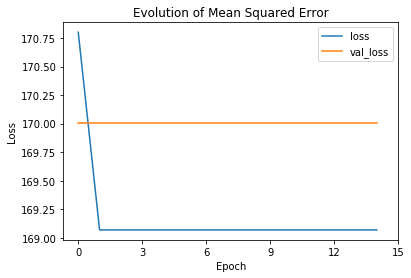

In [47]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [48]:
print(X_val.shape)
print(y_val.shape)

(1000, 224, 224, 1)
(1000, 2)


In [49]:
y_hat = model.predict([X_val,t_val])
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[:,0]
y_hat_long=y_hat[:,1]

y_hat_lat=scale_up(y_hat_lat,latend,latstart)
y_hat_long=scale_up(y_hat_long,longend,longstart)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,latend,latstart)
y_val_long=scale_up(y_val_long,longend,longstart)

(36, 40)

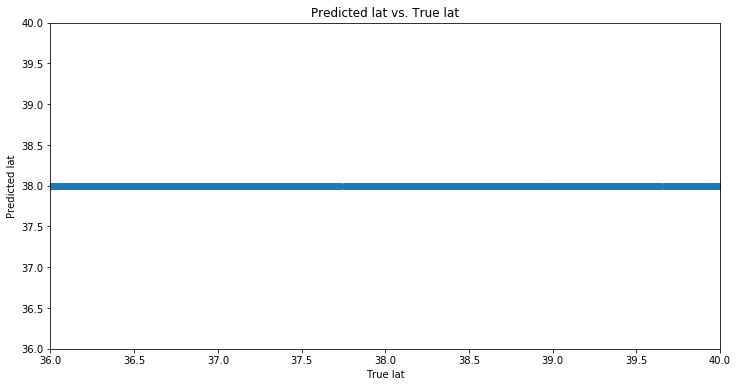

In [51]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
ax.set_xlim(36,40)
ax.set_ylim(36,40)
#draw straight line


(-78, -74)

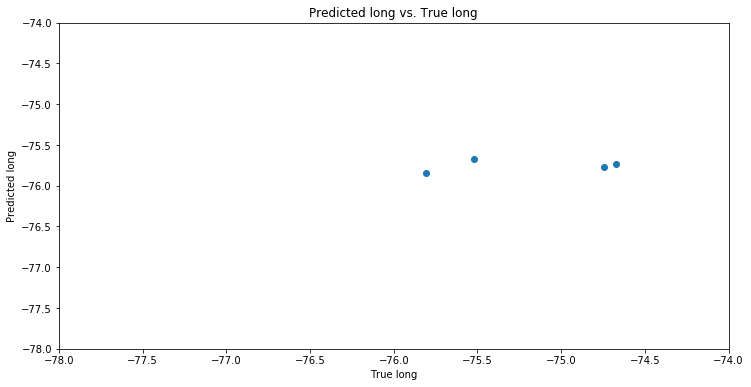

In [36]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
ax.set_xlim(-78,-74)
ax.set_ylim(-78,-74)


### Save Model

In [23]:
model_dir='inference_model'
model.save(model_dir)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inference_model/assets


In [36]:
test_model=tf.keras.models.load_model(model_dir)


In [24]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)

### Feed Forward Dense

In [38]:
#just dense

input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50176)        0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 528)          26493456    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 528)          279312      dense_11[0][0]                   
____________________________________________________________________________________________

In [39]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 8s 2ms/sample - loss: 2.0387 - regression_lat_loss: 0.8447 - regression_long_loss: 1.1658 - regression_lat_mean_squared_error: 0.8550 - regression_long_mean_squared_error: 1.1837 - val_loss: 0.6580 - val_regression_lat_loss: 0.3201 - val_regression_long_loss: 0.3377 - val_regression_lat_mean_squared_error: 0.3201 - val_regression_long_mean_squared_error: 0.3379
Epoch 2/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6928 - regression_lat_loss: 0.3413 - regression_long_loss: 0.3514 - regression_lat_mean_squared_error: 0.3413 - regression_long_mean_squared_error: 0.3516 - val_loss: 0.6555 - val_regression_lat_loss: 0.3144 - val_regression_long_loss: 0.3413 - val_regression_lat_mean_squared_error: 0.3143 - val_regression_long_mean_squared_error: 0.3412
Epoch 3/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6259 - regression_lat_loss: 0.30

In [40]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

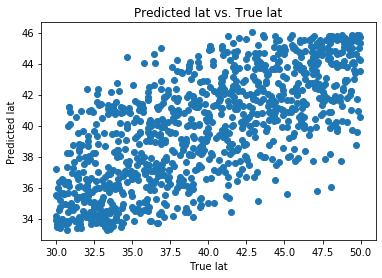

In [41]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

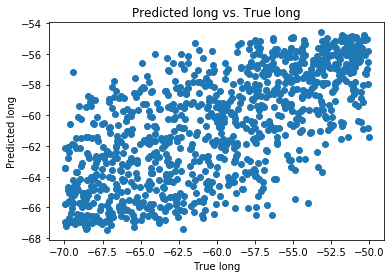

In [42]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time
- change angle of view - look more tired horizon?


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
#model splits into lat long after convolutional layers

input_shape=(270,480,1)
input = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])

In [ ]:
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)